## Project 3 - Subreddit 
### by Steven Tran

<span style='color: red;'>Add TOC when available</span>

---

# 02: Cleaning and EDA


In [1]:
# imports:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# using this option from lesson 5.05 modeling with VADER to display more text in columns:
pd.options.display.max_colwidth = 200

In [2]:
#read in data:
pf = pd.read_csv('../data/posts__personal_finance.csv')
finplan = pd.read_csv('../data/posts__financial_planning.csv')
unpop = pd.read_csv('../data/posts__unpopular_opinion.csv')
omc = pd.read_csv('../data/posts__offmychest.csv')
dj = pd.read_csv('../data/posts__dad_jokes.csv')
jokes = pd.read_csv('../data/posts__jokes.csv')

---

### Clean up `title` and `selftext`

To consistently clean the `title` and `selftext` fields in each of our subreddits, I'll define a function to accomplish the following in the cell below:
1. Remove NAs `df.dropna(inplace=True)`
1. Remove newlines `\n`, special quotes `chr(8220) and chr(8221)`, and zero-width space characters `#x200B`
     * method inspired by [this stackoverflow answer](https://stackoverflow.com/a/1919112)
1. Trim any leading or trailing whitespace using `.strip()`

In [4]:
def clean_text(df, series):
    #dictionary for string replacement inspired by this stackoverflow answer: https://stackoverflow.com/a/1919112
    df.drop(df[df[series].isna()].index,inplace=True)
    replacements = {'\n': '',
                    chr(8220): chr(34),
                    chr(8221): chr(34),
                    '#x200B;': ' '}
    
    #reset indices:
    df.reset_index(drop=True,inplace=True)
    
    #do replacements
    for k, v in replacements.items():
        df.loc[:,series] = df[series].str.replace(k,v)
        
    df.loc[:,series] = df[series].str.strip()


In [5]:
dataframes = {'personal_finance': pf,
              'financial_planning': finplan,
              'unpopular_opinion': unpop,
              'offmychest': omc,
              'dad_jokes': dj,
              'jokes': jokes,
             }

columns = ['title','selftext']

for dataframe in dataframes:
    for column in columns:
        clean_text(dataframes.get(dataframe),column)

In [6]:
# see now how many rows are left in each DF:
for dataframe in dataframes:
    print(f'{dataframe}: {dataframes.get(dataframe).shape[0]} rows.')

personal_finance: 7947 rows.
financial_planning: 5813 rows.
unpopular_opinion: 8000 rows.
offmychest: 8000 rows.
dad_jokes: 7941 rows.
jokes: 7999 rows.


---

### Reformat dates

Will convert the `created_utc` to a datetime. Method inspired by this [webpost](https://pythonguides.com/python-epoch-to-datetime/).

In [9]:
#convert utc int to datetime:
import datetime
for dataframe in dataframes:
    dataframes.get(dataframe)['created_utc'] = [datetime.datetime.fromtimestamp(utc).strftime('%Y-%m-%d %H:%M:%S') for utc in dataframes.get(dataframe)['created_utc']]


---

# EDA

For EDA, I'd like to accomplish the following for each subreddit:
* Get mean `title` and `selftext` word count.
* get mean `title` and `selftext` string length.


In [30]:
title_text_stats = {}

for dataframe in dataframes:
    df = dataframes.get(dataframe)
    #get wordlengths:
    df['title_wordlen'] = df['title'].map(lambda x: len(x.split(' ')))
    df['text_wordlen'] = df['selftext'].map(lambda x: len(x.split(' ')))
    #get stringlengths
    df['title_strlen'] = df['title'].apply(len)
    df['text_strlen'] = df['selftext'].apply(len)

    title_text_stats[dataframe] = {
        'mean_title_wordlen': df['title_wordlen'].mean(),
        'mean_title_strlen': df['title_strlen'].mean(),
        'mean_text_wordlen': df['text_wordlen'].mean(),
        'mean_text_strlen': df['text_strlen'].mean(),
        'count_posts': int(df.shape[0]),
    }

In [31]:
title_text_stats = pd.DataFrame.from_dict(title_text_stats).T

In [32]:
title_text_stats

,mean_title_wordlen,mean_title_strlen,mean_text_wordlen,mean_text_strlen,count_posts
personal_finance,10.091733,55.879955,152.678369,814.699132,7947.0
financial_planning,8.813693,48.912094,149.101153,802.864958,5813.0
unpopular_opinion,10.979750,62.614875,117.398250,649.405875,8000.0
offmychest,9.457750,48.703250,263.944125,1370.431500,8000.0
dad_jokes,10.063342,52.260547,8.541242,45.494522,7941.0
jokes,10.130391,52.811976,33.105638,178.861233,7999.0


In [48]:
for i in range(6):
    print(i,i//2,i%2)

0 0 0
1 0 1
2 1 0
3 1 1
4 2 0
5 2 1


## Plot `title` stats:

* Word counts:

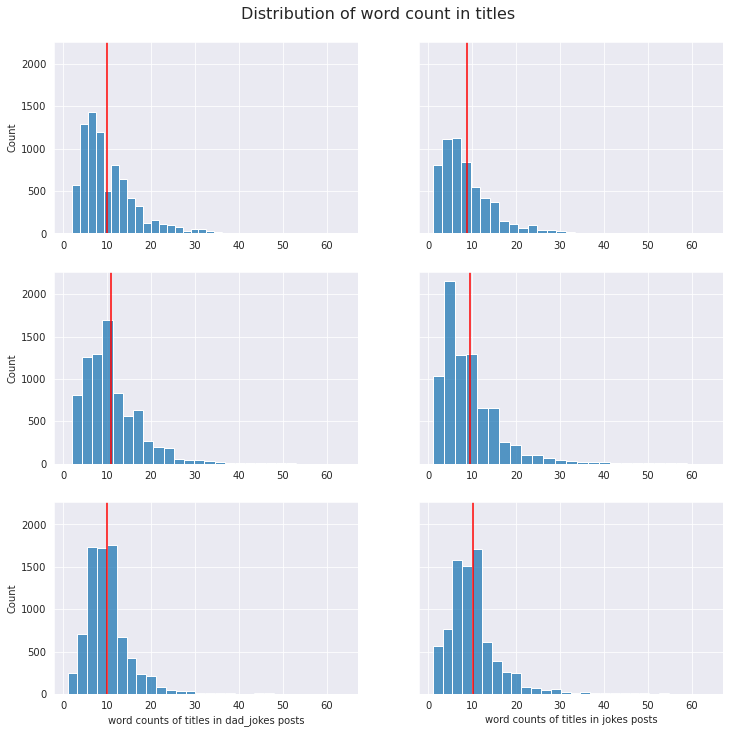

In [81]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(3,2,figsize=(12,12), sharex = True, sharey= True)
    fig.suptitle('Distribution of word count in titles', y = 0.92, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['title_wordlen'], bins=25,ax=axs[i//2,i%2])
        axs[i//2,i%2].axvline(x=title_text_stats.loc[dataframe,'mean_title_wordlen'], color = 'red')
        axs[i//2,i%2].set(xlabel=f'word counts of titles in {dataframe} posts')
        axs[i//2,i%2].tick_params(labelbottom=True)

* String lengths:

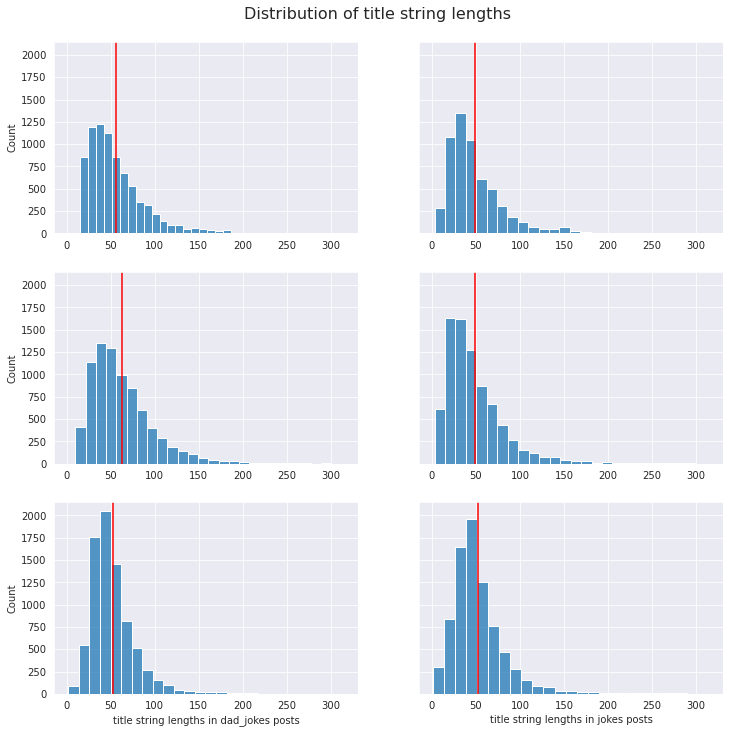

In [82]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(3,2,figsize=(12,12), sharex = True, sharey=True)
    fig.suptitle('Distribution of title string lengths', y = 0.92, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['title_strlen'], bins=25,ax=axs[i//2,i%2])
        axs[i//2,i%2].axvline(x=title_text_stats.loc[dataframe,'mean_title_strlen'], color = 'red')
        axs[i//2,i%2].set(xlabel=f'title string lengths in {dataframe} posts')
        axs[i//2,i%2].tick_params(labelbottom=True)

## Plot `selftext` stats:

* Word counts:

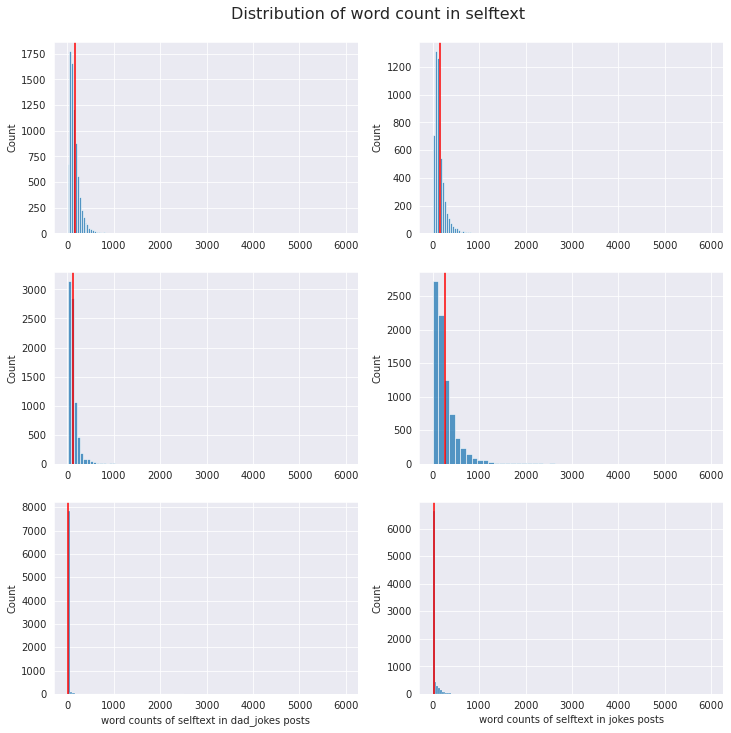

In [83]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(3,2,figsize=(12,12), sharex = True)
    fig.suptitle('Distribution of word count in selftext', y = 0.92, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['text_wordlen'], bins=50,ax=axs[i//2,i%2])
        axs[i//2,i%2].axvline(x=title_text_stats.loc[dataframe,'mean_text_wordlen'], color = 'red')
        axs[i//2,i%2].set(xlabel=f'word counts of selftext in {dataframe} posts')
        axs[i//2,i%2].tick_params(labelbottom=True)

* String lengths:

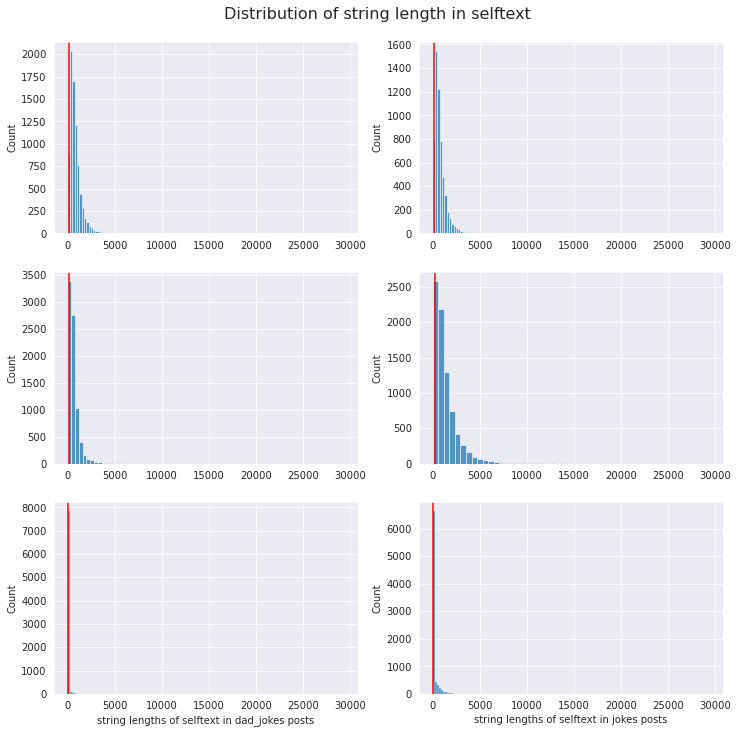

In [85]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(3,2,figsize=(12,12), sharex = True)
    fig.suptitle('Distribution of string length in selftext', y = 0.92, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['text_strlen'], bins=50,ax=axs[i//2,i%2])
        axs[i//2,i%2].axvline(x=title_text_stats.loc[dataframe,'mean_text_wordlen'], color = 'red')
        axs[i//2,i%2].set(xlabel=f'string lengths of selftext in {dataframe} posts')
        axs[i//2,i%2].tick_params(labelbottom=True)

---

# Create mixed dataframes:

* `personal_finance` with `financial_planning`
* `unpopular_opinion` with `off_my_chest`
* `dad_jokes` with `jokes`

In [95]:
jokes['subreddit']

0       Jokes
1       Jokes
2       Jokes
3       Jokes
4       Jokes
        ...  
7994    Jokes
7995    Jokes
7996    Jokes
7997    Jokes
7998    Jokes
Name: subreddit, Length: 7999, dtype: object

In [87]:
finances = pd.concat([pf,finplan],ignore_index=True)
controversial = pd.concat([unpop,omc],ignore_index=True)
all_jokes = pd.concat([dj,jokes],ignore_index=True)

In [97]:
finances.loc[:,'subreddit'] = finances['subreddit'].map({'personalfinance': 1, 'FinancialPlanning': 0})
controversial.loc[:,'subreddit'] = controversial['subreddit'].map({'unpopularopinion': 1, 'offmychest': 0})
all_jokes.loc[:,'subreddit'] = all_jokes['subreddit'].map({'dadjokes': 1, 'Jokes': 0})

---

## Some correlation plots:

<AxesSubplot:>

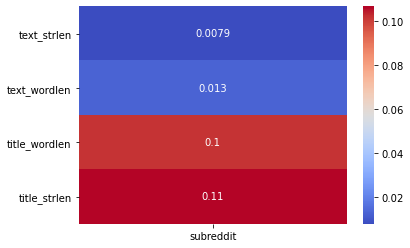

In [105]:
sns.heatmap(finances.corr()[['subreddit']].sort_values('subreddit')[:-1],annot=True,cmap='coolwarm')

<AxesSubplot:>

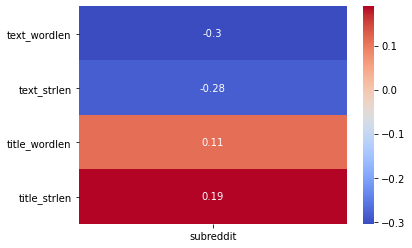

In [106]:
sns.heatmap(controversial.corr()[['subreddit']].sort_values('subreddit')[:-1],annot=True,cmap='coolwarm')

<AxesSubplot:>

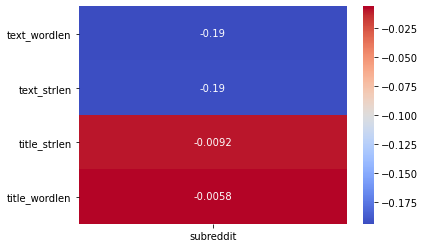

In [107]:
sns.heatmap(all_jokes.corr()[['subreddit']].sort_values('subreddit')[:-1],annot=True,cmap='coolwarm')

---

Save and export cleaned data:



In [108]:
finances.to_csv('../data/cleaned/personalfinance.csv',index=False)
controversial.to_csv('../data/cleaned/unpopularopinions.csv',index=False)
all_jokes.to_csv('../data/cleaned/dadjokes.csv',index=False)